### ¿Qué es un **Treap**?

Un **treap** es una estructura de datos que combina:

- **Árbol binario de búsqueda (BST):**  
  Permite búsquedas, inserciones y eliminaciones eficientes en tiempo logarítmico en promedio, siempre que el árbol esté balanceado, gracias a la propiedad de orden de las claves.

- **Heap de prioridades (min-heap en este caso):**  
  Cada nodo tiene una prioridad, y se garantiza que la prioridad de cada nodo es menor que la de sus hijos. Esto asegura que el nodo con la mayor "importancia" (prioridad mínima) se encuentre en la raíz.

La combinación de ambas propiedades permite que el árbol se mantenga *aproximadamente balanceado* de forma aleatoria. Las prioridades suelen asignarse de forma aleatoria (o utilizando otro criterio) para que la estructura garantice tiempos de operación promedio de $O(\log n)$ tanto en búsquedas como en inserciones y eliminaciones.

El código  ofrece una implementación completa y **thread-safe** de un treap en Python, permitiendo realizar todas las operaciones clásicas (búsqueda, inserción, eliminación y actualización de prioridad) manteniendo simultáneamente las propiedades del BST y del min-heap. Esto resulta útil para escenarios donde se requiera un balance adecuado y un rendimiento predecible en operaciones dinámicas sobre conjuntos de datos.


In [2]:
import threading
from typing import Optional, TypeVar, Generic, Tuple

T = TypeVar('T')
S = TypeVar('S')

class Treap(Generic[T, S]):
    """
    Implementación de un Treap, una estructura de datos híbrida de
    Árbol Binario de Búsqueda (BST) y Heap (min-heap en prioridad).

    Uso thread-safe con RLock.
    """

    class _TreapNode:
        def __init__(self, key: T, priority: S):
            self.key: T = key
            self.priority: S = priority
            self.left: Optional['Treap._TreapNode'] = None
            self.right: Optional['Treap._TreapNode'] = None
            self.parent: Optional['Treap._TreapNode'] = None

        def is_leaf(self) -> bool:
            return self.left is None and self.right is None

        def is_root(self) -> bool:
            return self.parent is None

        def is_left_child(self) -> bool:
            return (self.parent is not None) and (self.parent.left is self)

        def is_right_child(self) -> bool:
            return (self.parent is not None) and (self.parent.right is self)

        # Búsqueda
        def search(self,
                   target_key: Optional[T] = None,
                   target_priority: Optional[S] = None
                   ) -> Optional['Treap._TreapNode']:
            """
            Busca recursivamente un nodo con clave == target_key (si no es None)
            y prioridad == target_priority (si no es None).
            """
            if ((target_key is None or target_key == self.key) and
                (target_priority is None or target_priority == self.priority)):
                return self

            result = None
            if target_key is None or target_key <= self.key:
                if self.left is not None:
                    result = self.left.search(target_key, target_priority)
            if result is None and (target_key is None or target_key > self.key):
                if self.right is not None:
                    result = self.right.search(target_key, target_priority)
            return result

        # Medidas
        def size(self) -> int:
            return 1 + (self.left.size() if self.left else 0) + (self.right.size() if self.right else 0)

        def height(self) -> int:
            return 1 + max((self.left.height() if self.left else 0),
                           (self.right.height() if self.right else 0))

        def min(self) -> T:
            return self.left.min() if self.left else self.key

        def max(self) -> T:
            return self.right.max() if self.right else self.key

        # Inserción (clásica)
        def add(self, key: T, priority: S, treap: 'Treap') -> 'Treap._TreapNode':
            """
            Inserta un nuevo nodo (key, priority) respetando la propiedad BST en 'key'.
            Se asume que claves iguales se insertan en el subárbol izquierdo.
            Luego se verifica (y, en su caso, se corrige) la propiedad de heap.
            """
            if key <= self.key:
                if self.left is not None:
                    self.left = self.left.add(key, priority, treap)
                    self.left.parent = self
                else:
                    self.left = Treap._TreapNode(key, priority)
                    self.left.parent = self
                if treap.has_higher_priority(self.left.priority, self.priority):
                    return self.rotate_right(treap)
                else:
                    return self
            else:
                if self.right is not None:
                    self.right = self.right.add(key, priority, treap)
                    self.right.parent = self
                else:
                    self.right = Treap._TreapNode(key, priority)
                    self.right.parent = self
                if treap.has_higher_priority(self.right.priority, self.priority):
                    return self.rotate_left(treap)
                else:
                    return self

        # Rotaciones clásicas
        def rotate_left(self, treap: 'Treap') -> 'Treap._TreapNode':
            r"""
            Realiza una rotación a la izquierda.
            Sea x = self y y = x.right. Tras la rotación, y se convierte en la nueva raíz
            de este subárbol, y x pasa a ser su hijo izquierdo.
            """
            y = self.right
            if y is None:
                return self  # no se puede rotar
            self.right = y.left
            if y.left is not None:
                y.left.parent = self
            y.left = self
            y.parent = self.parent
            if self.parent is None:
                treap.root = y
            else:
                if self.is_left_child():
                    self.parent.left = y
                else:
                    self.parent.right = y
            self.parent = y
            return y

        def rotate_right(self, treap: 'Treap') -> 'Treap._TreapNode':
            """
            Realiza una rotación a la derecha.
            Sea x = self y y = x.left. Tras la rotación, y se convierte en la nueva raíz
            de este subárbol, y x pasa a ser su hijo derecho.
            """
            x = self.left
            if x is None:
                return self
            self.left = x.right
            if x.right is not None:
                x.right.parent = self
            x.right = self
            x.parent = self.parent
            if self.parent is None:
                treap.root = x
            else:
                if self.is_left_child():
                    self.parent.left = x
                else:
                    self.parent.right = x
            self.parent = x
            return x

        # Actualización de prioridad con algoritmo iterativo sencillo
        def update_priority(self, new_priority: S, treap: 'Treap') -> 'Treap._TreapNode':
            """
            Actualiza la prioridad del nodo y lo reubica en el árbol.
            Se realiza en dos fases:
              - Bubble-up: se rota mientras la nueva prioridad sea estrictamente menor que la del padre.
              - Push-down: se rota mientras algún hijo tenga prioridad estrictamente menor.
            Se utilizan comparaciones estrictas para evitar oscilaciones.
            """
            self.priority = new_priority
            # Bubble-up: mientras el nodo tenga padre y su prioridad sea menor que la del padre
            while self.parent is not None and self.priority < self.parent.priority:
                if self.is_left_child():
                    self = self.parent.rotate_right(treap)
                else:
                    self = self.parent.rotate_left(treap)
            # Push-down: mientras alguno de sus hijos tenga prioridad menor
            while True:
                changed = False
                if self.left is not None and self.left.priority < self.priority:
                    self = self.rotate_right(treap)
                    changed = True
                elif self.right is not None and self.right.priority < self.priority:
                    self = self.rotate_left(treap)
                    changed = True
                if not changed:
                    break
            return self

        # Eliminación recursiva interna
        def _remove(self, key: T, priority: S, treap: 'Treap') -> Tuple[Optional['Treap._TreapNode'], bool]:
            """
            Elimina recursivamente el nodo que coincida con (key, priority)
            y retorna (nuevo_subárbol, True/False si se eliminó).
            """
            if key < self.key:
                if self.left:
                    new_left, deleted = self.left._remove(key, priority, treap)
                    self.left = new_left
                    if new_left:
                        new_left.parent = self
                    return (self, deleted)
                else:
                    return (self, False)
            elif key > self.key:
                if self.right:
                    new_right, deleted = self.right._remove(key, priority, treap)
                    self.right = new_right
                    if new_right:
                        new_right.parent = self
                    return (self, deleted)
                else:
                    return (self, False)
            else:
                # Clave igual; si la prioridad no coincide, se busca en los hijos.
                if self.priority != priority:
                    if self.left:
                        new_left, deleted = self.left._remove(key, priority, treap)
                        self.left = new_left
                        if new_left:
                            new_left.parent = self
                        if deleted:
                            return (self, True)
                    if self.right:
                        new_right, deleted = self.right._remove(key, priority, treap)
                        self.right = new_right
                        if new_right:
                            new_right.parent = self
                        return (self, deleted)
                    return (self, False)
                # Nodo encontrado.
                if self.left is None:
                    if self.right:
                        self.right.parent = self.parent
                    return (self.right, True)
                elif self.right is None:
                    if self.left:
                        self.left.parent = self.parent
                    return (self.left, True)
                else:
                    # Ambos hijos existen: se rota según la prioridad del hijo más "bueno"
                    if treap.has_higher_priority(self.left.priority, self.right.priority):
                        new_root = self.rotate_right(treap)
                        new_root.right, _ = new_root.right._remove(key, priority, treap)
                        if new_root.right:
                            new_root.right.parent = new_root
                        return (new_root, True)
                    else:
                        new_root = self.rotate_left(treap)
                        new_root.left, _ = new_root.left._remove(key, priority, treap)
                        if new_root.left:
                            new_root.left.parent = new_root
                        return (new_root, True)

        def clean_up(self):
            if self.left:
                self.left.clean_up()
                self.left = None
            if self.right:
                self.right.clean_up()
                self.right = None
            self.parent = None

        def check_treap_invariants(self, treap: 'Treap') -> bool:
            if self.left is not None:
                if (treap.has_higher_priority(self.left.priority, self.priority)
                    or self.left.key > self.key):
                    return False
            if self.right is not None:
                if (treap.has_higher_priority(self.right.priority, self.priority)
                    or self.right.key <= self.key):
                    return False
            left_ok = self.left.check_treap_invariants(treap) if self.left else True
            right_ok = self.right.check_treap_invariants(treap) if self.right else True
            return left_ok and right_ok

    class TreapEntry:
        """
        Par (clave, prioridad) usado en operaciones públicas del Treap.
        """
        def __init__(self, key: T, priority: S):
            self.key = key
            self.priority = priority

        def get_key(self) -> T:
            return self.key

        def get_priority(self) -> S:
            return self.priority

        def __lt__(self, other: 'Treap.TreapEntry') -> bool:
            if other is None:
                return False
            return self.priority < other.priority

    def __init__(self):
        self.root: Optional[Treap._TreapNode] = None
        self._lock = threading.RLock()

    def has_higher_priority(self, first: S, second: S) -> bool:
        # Menor valor => mayor prioridad
        return first < second

    # Métodos públicos
    def size(self) -> int:
        with self._lock:
            return self.root.size() if self.root else 0

    def height(self) -> int:
        with self._lock:
            return self.root.height() if self.root else 0

    def is_empty(self) -> bool:
        with self._lock:
            return self.root is None

    def min(self) -> Optional[T]:
        with self._lock:
            return self.root.min() if self.root else None

    def max(self) -> Optional[T]:
        with self._lock:
            return self.root.max() if self.root else None

    def search(self, key: T) -> Optional[T]:
        with self._lock:
            node = self.root.search(target_key=key) if self.root else None
            return node.key if node else None

    def contains(self, entry: 'Treap.TreapEntry') -> bool:
        with self._lock:
            if not self.root:
                return False
            node = self.root.search(target_key=entry.get_key(),
                                    target_priority=entry.get_priority())
            return node is not None

    def add(self, entry: 'Treap.TreapEntry') -> bool:
        """
        Inserta la entrada siempre retornando True (como en los tests),
        incluso si ya existía.
        """
        with self._lock:
            if self.root is None:
                self.root = Treap._TreapNode(entry.get_key(), entry.get_priority())
            else:
                self.root = self.root.add(entry.get_key(), entry.get_priority(), self)
            return True

    def update_priority(self, old_entry: 'Treap.TreapEntry', new_entry: 'Treap.TreapEntry') -> bool:
        if old_entry.get_key() != new_entry.get_key():
            raise ValueError("Las dos entradas deben tener la misma clave")
        if old_entry.get_priority() == new_entry.get_priority():
            return False
        with self._lock:
            if not self.root:
                return False
            target = self.root.search(target_key=old_entry.get_key(),
                                      target_priority=old_entry.get_priority())
            if not target:
                return False
            new_node = target.update_priority(new_entry.get_priority(), self)
            if new_node.parent is None:
                self.root = new_node
            return True

    def remove(self, entry: 'Treap.TreapEntry') -> bool:
        """
        Elimina el nodo que coincida con (key, priority).
        Retorna True si se eliminó.
        """
        with self._lock:
            if self.root is None:
                return False
            new_root, deleted = self.root._remove(entry.get_key(), entry.get_priority(), self)
            self.root = new_root
            return deleted

    def remove_key(self, key: T) -> bool:
        """
        Elimina UNA copia de la clave 'key'. Se llama repetidamente
        para remover duplicados.
        """
        with self._lock:
            if self.root is None:
                return False
            node = self.root.search(target_key=key)
            if not node:
                return False
            self.root, deleted = self.root._remove(key, node.priority, self)
            return deleted

    def clear(self):
        with self._lock:
            old_root = self.root
            self.root = None
        if old_root:
            old_root.clean_up()

    def check_treap_invariants(self) -> bool:
        with self._lock:
            return self.root.check_treap_invariants(self) if self.root else True

    def check_bst_invariants(self) -> bool:
        with self._lock:
            return self.root.check_treap_invariants(self) if self.root else True

    def peek(self) -> Optional['Treap.TreapEntry']:
        """
        Retorna la raíz (elemento de mayor prioridad) sin eliminarla.
        """
        with self._lock:
            if not self.root:
                return None
            return Treap.TreapEntry(self.root.key, self.root.priority)

    def top(self) -> Optional['Treap.TreapEntry']:
        """
        Extrae y elimina la raíz (elemento de mayor prioridad) y la retorna.
        Se utiliza remove() para eliminar la entrada.
        """
        with self._lock:
            if not self.root:
                return None
            result = Treap.TreapEntry(self.root.key, self.root.priority)
            self.remove(result)
            return result


### Pruebas

El código utiliza el módulo `unittest` de Python para definir una batería de pruebas que validan el comportamiento de la implementación de la estructura de datos Treap (árbol binario de búsqueda combinado con un min-heap). Además, se importa `random` para generar datos aleatorios y se usa `typing.List` para especificar el tipo de las listas utilizadas en las funciones auxiliares.  

La clase `TestTreap` hereda de `unittest.TestCase` y contiene varios métodos de prueba, cada uno destinado a examinar una funcionalidad diferente del Treap:

1. **setUp**:  Se utiliza `random.seed(0)` para asegurar la reproducibilidad de las pruebas que involucran valores aleatorios.

2. **init_treap**:   Esta función auxiliar recibe dos listas (claves y prioridades) y crea un Treap, añadiendo cada elemento mediante `treap.add(Treap.TreapEntry(key, priority))`. Verifica que ambas listas tengan la misma longitud, lanzando un error en caso contrario.

3. **test_top**:  Verifica que el método `top()` retorne `None` en un Treap vacío, y tras insertar elementos, que devuelva el de mayor prioridad (donde menor valor numérico significa mayor prioridad). Además, se prueba que, tras eliminar el elemento raíz, las invariantes del Treap sigan cumpliéndose.

4. **test_peek**:  Comprueba que `peek()` retorne `None` al estar vacío y, al agregar elementos, que devuelva siempre el de mayor prioridad sin eliminarlo.

5. **test_add**:  Se prueba la operación de inserción verificando que el tamaño del treap se incremente y que los elementos se encuentren mediante `contains()`.

6. **test_update_priority y test_update_priority_fail**:  Evalúan la actualización de la prioridad de un nodo, comprobando que la operación se realice correctamente (manteniendo las invariantes) y que lance un `ValueError` cuando se intente actualizar la prioridad de un nodo a uno con clave diferente.

7. **test_remove y test_remove_key**:  Se validan los métodos de eliminación ya sea por una entrada exacta o solo por clave, comprobando que el tamaño disminuya y que los elementos se eliminen del Treap. En el caso de duplicados, se verifica que se eliminen de a uno.

8. **test_clear, test_size, test_height y test_is_empty**:  Estas pruebas aseguran que se comporten correctamente los métodos que retornan el tamaño, la altura y el estado (vacío o no) del Treap, y que la función `clear()` elimine todos los nodos.

9. **test_min y test_max**:  Verifican que los métodos `min()` y `max()` devuelvan las claves mínimas y máximas, respectivamente, utilizando la propiedad del BST.

10. **test_search y test_contains**:  Se prueban las funciones de búsqueda, confirmando que se encuentran elementos existentes y se rechacen búsquedas incorrectas o de entradas inexistentes.

Finalmente, `unittest.main(argv=[''], verbosity=2, exit=False)` se encarga de ejecutar las pruebas con una salida detallada y sin detener la ejecución del intérprete. Este conjunto de pruebas permite validar de manera exhaustiva que el Treap cumpla con sus especificaciones de funcionamiento y mantenimiento de invariante.

In [4]:
import unittest
import random
from typing import List

# Se asume que el código de la clase Treap está definido en el mismo módulo o importado adecuadamente.
# Por ejemplo:
# from treap import Treap

class TestTreap(unittest.TestCase):
    def setUp(self):
        # Para reproducibilidad en pruebas que usan números aleatorios
        random.seed(0)

    def init_treap(self, keys: List, priorities: List) -> Treap:
        """
        Inicializa un Treap a partir de dos listas: claves y prioridades,
        asegurándose de que ambas tengan la misma longitud.
        
        Args:
            keys (List): Lista de claves.
            priorities (List): Lista de prioridades.
        
        Returns:
            Treap: El treap inicializado con las entradas correspondientes.
        """
        if len(keys) != len(priorities):
            raise ValueError("Both lists must have the same length")
        treap = Treap()
        for key, priority in zip(keys, priorities):
            treap.add(Treap.TreapEntry(key, priority))
        return treap

    def test_top(self):
        # Prueba de top() en treap vacío
        treap = Treap()
        self.assertIsNone(treap.top(), "top() debe retornar None cuando el treap está vacío")
        
        # Agregar un solo elemento y comprobar top()
        treap.add(Treap.TreapEntry("primo", 1.0))
        result = treap.top()
        self.assertIsNotNone(result, "top() debe retornar un elemento válido cuando el treap no está vacío")
        self.assertEqual(result.get_key(), "primo", "top() debe retornar el único elemento del treap")
        self.assertTrue(treap.is_empty(), "Después de top() el treap debe quedar vacío")
        
        # Agregar múltiples entradas con prioridades variadas
        treap.add(Treap.TreapEntry("primo", 1.0))
        treap.add(Treap.TreapEntry("primo", 1.0))
        treap.add(Treap.TreapEntry("secondo", -1.0))
        treap.add(Treap.TreapEntry("a", 11.0))
        treap.add(Treap.TreapEntry("b", 0.0))
        treap.add(Treap.TreapEntry("c", -0.99))
        result = treap.top()
        # Entre "secondo" con prioridad -1.0 y "c" con -0.99, se espera que "secondo" (con menor valor) sea el de mayor prioridad.
        self.assertEqual(result.get_key(), "secondo", "top() debe retornar el elemento de mayor prioridad")
        
        # Agregar elementos aleatorios y verificar invariantes
        for _ in range(10):
            treap.add(Treap.TreapEntry(str(random.randint(0, 1000)), random.random()))
            self.assertTrue(treap.check_treap_invariants(), "Las invariantes del treap deben mantenerse")
        while not treap.is_empty():
            self.assertTrue(treap.check_treap_invariants(), "Las invariantes del treap deben mantenerse")
            treap.top()

    def test_peek(self):
        treap = Treap()
        # peek() en treap vacío devuelve None
        self.assertIsNone(treap.peek(), "peek() debe retornar None cuando el treap está vacío")
        
        treap.add(Treap.TreapEntry("primo", 1e14))
        result = treap.peek()
        self.assertIsNotNone(result, "peek() debe retornar un elemento válido si el treap no está vacío")
        self.assertEqual(result.get_key(), "primo", "peek() debe retornar el único elemento del treap")
        
        # Agregar más elementos y verificar que peek() siempre retorne el de mayor prioridad
        treap.add(Treap.TreapEntry("b", 0.0))
        treap.add(Treap.TreapEntry("c", -0.99))
        treap.add(Treap.TreapEntry("secondo", -1.0))
        treap.add(Treap.TreapEntry("a", 11.0))
        result = treap.peek()
        self.assertEqual(result.get_key(), "secondo", "peek() debe retornar el elemento de mayor prioridad")

    def test_add(self):
        treap = Treap()
        self.assertEqual(treap.size(), 0, "El tamaño debe ser 0 en un treap vacío")
        
        self.assertTrue(treap.add(Treap.TreapEntry("d", 1.0)))
        self.assertEqual(treap.size(), 1)
        self.assertTrue(treap.contains(Treap.TreapEntry("d", 1.0)))
        
        self.assertTrue(treap.add(Treap.TreapEntry("c", 2.0)))
        self.assertEqual(treap.size(), 2)
        self.assertTrue(treap.contains(Treap.TreapEntry("c", 2.0)))
        
        self.assertTrue(treap.add(Treap.TreapEntry("c", 2.0)))
        self.assertEqual(treap.size(), 3)
        self.assertTrue(treap.contains(Treap.TreapEntry("c", 2.0)))
        
        self.assertTrue(treap.add(Treap.TreapEntry("e", -1.0)))
        self.assertEqual(treap.size(), 4)
        self.assertTrue(treap.contains(Treap.TreapEntry("e", -1.0)))
        
        self.assertTrue(treap.add(Treap.TreapEntry("f", 0.0)))
        self.assertEqual(treap.size(), 5)
        self.assertTrue(treap.contains(Treap.TreapEntry("f", 0.0)))
        
        self.assertTrue(treap.add(Treap.TreapEntry("a", 2.0)))
        self.assertEqual(treap.size(), 6)
        self.assertTrue(treap.contains(Treap.TreapEntry("a", 2.0)))
        
        self.assertTrue(treap.add(Treap.TreapEntry("a", 123.0)))
        self.assertEqual(treap.size(), 7)
        self.assertTrue(treap.contains(Treap.TreapEntry("a", 123.0)))

    def test_update_priority(self):
        keys = ["a", "b", "c", "d", "e", "f", "g"]
        priorities = list(range(7))  # [0, 1, 2, 3, 4, 5, 6]
        treap = self.init_treap(keys, priorities)
        
        # Casos que deben retornar False (clave no encontrada o prioridad no coincide)
        self.assertFalse(treap.update_priority(Treap.TreapEntry("d", 2), Treap.TreapEntry("d", 1)))
        self.assertFalse(treap.update_priority(Treap.TreapEntry("a", -1), Treap.TreapEntry("a", 0)))
        self.assertFalse(treap.update_priority(Treap.TreapEntry("a", 0), Treap.TreapEntry("a", 0)))
        
        # Actualización legítima
        self.assertTrue(treap.update_priority(Treap.TreapEntry("b", 1), Treap.TreapEntry("b", 7)))
        self.assertTrue(treap.check_treap_invariants(), "Las invariantes no deben romperse tras update_priority")
        self.assertFalse(treap.contains(Treap.TreapEntry("b", 1)))
        self.assertTrue(treap.contains(Treap.TreapEntry("b", 7)))
        
        self.assertTrue(treap.update_priority(Treap.TreapEntry("c", 2), Treap.TreapEntry("c", -1)))
        self.assertTrue(treap.check_treap_invariants(), "Las invariantes no deben romperse tras update_priority")
        self.assertEqual(treap.top().get_key(), "c", "El elemento 'c' debe tener la máxima prioridad tras la actualización")
        
        self.assertTrue(treap.update_priority(Treap.TreapEntry("a", 0), Treap.TreapEntry("a", 4)))
        self.assertTrue(treap.check_treap_invariants(), "Las invariantes no deben romperse tras update_priority")
        self.assertEqual(treap.top().get_key(), "d", "Después de actualizar la raíz, se espera que 'd' sea el top")

    def test_update_priority_fail(self):
        treap = Treap()
        treap.add(Treap.TreapEntry("a", 0))
        with self.assertRaises(ValueError, msg="Debe lanzar ValueError si las claves no coinciden"):
            treap.update_priority(Treap.TreapEntry("a", 2), Treap.TreapEntry("c", 2))
        
    def test_remove(self):
        keys = list(range(9))
        priorities = [random.random() for _ in keys]
        treap = self.init_treap(keys, priorities)
        self.assertEqual(treap.size(), len(keys))
        
        random.shuffle(keys)
        for k in keys:
            current_size = treap.size()
            self.assertTrue(treap.remove(Treap.TreapEntry(k, priorities[k])), "Remove debe tener éxito")
            self.assertEqual(treap.size(), current_size - 1, "El tamaño debe disminuir en 1 tras remove")
            self.assertFalse(treap.contains(Treap.TreapEntry(k, priorities[k])), "El elemento debe haber sido eliminado")
        
    def test_remove_key(self):
        keys = list(range(9))
        priorities = [random.random() for _ in keys]
        treap = self.init_treap(keys, priorities)
        self.assertEqual(treap.size(), len(keys))
        
        random.shuffle(keys)
        for k in keys:
            current_size = treap.size()
            self.assertTrue(treap.remove_key(k), "remove_key debe tener éxito")
            self.assertEqual(treap.size(), current_size - 1, "El tamaño debe disminuir en 1 tras remove_key")
            self.assertFalse(treap.contains(Treap.TreapEntry(k, priorities[k])), "El elemento debe haber sido eliminado")
        
        # Probar con duplicados
        keys_dup = list(range(9))
        priorities_dup = [random.random() for _ in keys_dup]
        treap2 = self.init_treap(keys_dup, priorities_dup)
        treap2.add(Treap.TreapEntry(0, -10.0))
        self.assertEqual(treap2.size(), len(keys_dup) + 1)
        
        self.assertTrue(treap2.remove_key(0))
        self.assertEqual(treap2.size(), len(keys_dup))
        self.assertIsNotNone(treap2.search(0), "Debe existir al menos una copia del elemento duplicado")
        
        self.assertTrue(treap2.remove_key(0))
        self.assertEqual(treap2.size(), len(keys_dup) - 1)
        self.assertIsNone(treap2.search(0), "Todas las copias deben haber sido eliminadas")
    
    def test_clear(self):
        treap = Treap()
        num_elements = 5 + random.randint(0, 9)
        for i in range(num_elements):
            self.assertTrue(treap.add(Treap.TreapEntry(i, random.random())))
        self.assertEqual(treap.size(), num_elements)
        treap.clear()
        self.assertEqual(treap.size(), 0)
        self.assertTrue(treap.is_empty())
        treap.add(Treap.TreapEntry(1, 0.0))
        self.assertEqual(treap.size(), 1)
        self.assertFalse(treap.is_empty())
    
    def test_size(self):
        treap = Treap()
        self.assertEqual(treap.size(), 0, "El tamaño debe ser 0 en un treap vacío")
        
        treap.add(Treap.TreapEntry("a", 1.0))
        treap.add(Treap.TreapEntry("bcd", -1.0))
        self.assertEqual(treap.size(), 2, "El tamaño debe cambiar tras agregar elementos")
        treap.add(Treap.TreapEntry("a", 1.0))
        self.assertEqual(treap.size(), 3, "El tamaño debe aumentar incluso agregando duplicados")
        treap.add(Treap.TreapEntry("c", 3.1415))
        treap.add(Treap.TreapEntry("d", 3.1415))
        self.assertEqual(treap.size(), 5, "El tamaño debe aumentar con más elementos")
        self.assertTrue(treap.remove(Treap.TreapEntry("d", 3.1415)))
        self.assertEqual(treap.size(), 4, "El tamaño debe disminuir tras remover elementos")
        treap.remove(Treap.TreapEntry("bcd", -1.0))
        self.assertEqual(treap.size(), 3, "El tamaño debe disminuir tras remover elementos")
        treap.peek()
        self.assertEqual(treap.size(), 3, "El tamaño no debe cambiar al usar peek()")
        treap.top()
        self.assertEqual(treap.size(), 2, "El tamaño debe disminuir tras top()")
        treap.top()
        self.assertEqual(treap.size(), 1, "El tamaño debe disminuir tras top()")
    
    def test_height(self):
        treap = Treap()
        self.assertEqual(treap.height(), 0, "Un treap vacío debe tener altura 0")
        
        treap.add(Treap.TreapEntry("d", 1.0))
        self.assertEqual(treap.height(), 1)
        
        treap.add(Treap.TreapEntry("c", 2.0))
        self.assertEqual(treap.height(), 2)
        
        treap.remove(Treap.TreapEntry("c", 2.0))
        self.assertEqual(treap.height(), 1)
        
        treap.add(Treap.TreapEntry("e", -1.0))
        self.assertEqual(treap.height(), 2)
        
        treap.add(Treap.TreapEntry("f", 0.0))
        self.assertEqual(treap.height(), 2)
        
        treap.add(Treap.TreapEntry("c", 2.0))
        self.assertEqual(treap.height(), 3)
        
        treap.add(Treap.TreapEntry("x", 4.0))
        self.assertEqual(treap.height(), 3)
        
        treap.add(Treap.TreapEntry("y", 5.0))
        self.assertEqual(treap.height(), 4)
        
        treap.add(Treap.TreapEntry("w", 6.0))
        self.assertEqual(treap.height(), 4)
        
        treap.add(Treap.TreapEntry("z", 7.0))
        self.assertEqual(treap.height(), 5)
        
        treap.add(Treap.TreapEntry("xy", 7.0))
        self.assertEqual(treap.height(), 5)
    
    def test_is_empty(self):
        treap = Treap()
        self.assertTrue(treap.is_empty())
        
        self.assertTrue(treap.add(Treap.TreapEntry(1, 1.1)))
        self.assertFalse(treap.is_empty())
        
        self.assertTrue(treap.add(Treap.TreapEntry(2, -1.1)))
        self.assertFalse(treap.is_empty())
        
        self.assertTrue(treap.add(Treap.TreapEntry(1, 1.1)))
        self.assertFalse(treap.is_empty())
        
        self.assertTrue(treap.remove(Treap.TreapEntry(1, 1.1)))
        self.assertFalse(treap.is_empty())
        
        self.assertTrue(treap.remove(Treap.TreapEntry(2, -1.1)))
        self.assertFalse(treap.is_empty())
        
        self.assertTrue(treap.remove(Treap.TreapEntry(1, 1.1)))
        self.assertTrue(treap.is_empty())
    
    def test_min(self):
        # Prueba que min() retorne el menor elemento del treap
        keys = ["a", "b", "c", "d", "e", "f", "g"]
        random.shuffle(keys)
        treap = self.init_treap(keys, list(range(7)))
        self.assertEqual(treap.min(), "a")
    
    def test_max(self):
        # Prueba que max() retorne el mayor elemento del treap
        keys = ["a", "b", "c", "d", "e", "f", "g"]
        random.shuffle(keys)
        treap = self.init_treap(keys, list(range(7)))
        self.assertEqual(treap.max(), "g")
    
    def test_search(self):
        keys = ["a", "b", "c", "d", "e", "f", "g"]
        priorities = [random.random() for _ in range(7)]
        treap = self.init_treap(keys, priorities)
        
        # Búsqueda por clave
        self.assertEqual(treap.search("d"), "d", "Debe encontrar la entrada existente")
        self.assertIsNone(treap.search("z"), "Debe retornar None si la clave no existe")
    
    def test_contains(self):
        priorities = [random.random() for _ in range(7)]
        treap = self.init_treap(["a", "b", "c", "d", "e", "f", "g"], priorities)
        
        self.assertTrue(treap.contains(Treap.TreapEntry("d", priorities[3])),
                        "Debe encontrar la entrada existente")
        self.assertFalse(treap.contains(Treap.TreapEntry("d", -3.1415)),
                         "No debe encontrar una entrada con prioridad incorrecta")
        self.assertFalse(treap.contains(Treap.TreapEntry("z", 1.1)),
                         "No debe encontrar una entrada inexistente")


unittest.main(argv=[''], verbosity=2, exit=False)


test_add (__main__.TestTreap.test_add) ... ok
test_clear (__main__.TestTreap.test_clear) ... ok
test_contains (__main__.TestTreap.test_contains) ... ok
test_height (__main__.TestTreap.test_height) ... ok
test_is_empty (__main__.TestTreap.test_is_empty) ... ok
test_max (__main__.TestTreap.test_max) ... ok
test_min (__main__.TestTreap.test_min) ... ok
test_peek (__main__.TestTreap.test_peek) ... ok
test_remove (__main__.TestTreap.test_remove) ... ok
test_remove_key (__main__.TestTreap.test_remove_key) ... ok
test_search (__main__.TestTreap.test_search) ... ok
test_size (__main__.TestTreap.test_size) ... ok
test_top (__main__.TestTreap.test_top) ... ok
test_update_priority (__main__.TestTreap.test_update_priority) ... ok
test_update_priority_fail (__main__.TestTreap.test_update_priority_fail) ... ok

----------------------------------------------------------------------
Ran 15 tests in 0.018s

OK


Datos de profiling:
     n  run      time  height
0  100    0  0.000347      12
1  100    1  0.000424      14
2  100    2  0.000251      14
3  500    0  0.001580      20
4  500    1  0.001575      20
CSV guardado en: treap_profiling_results.csv


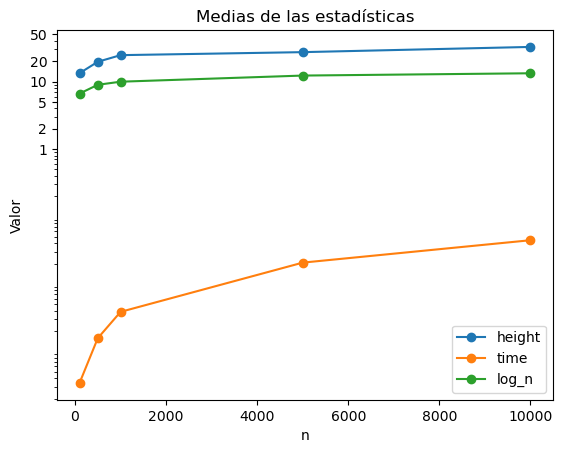

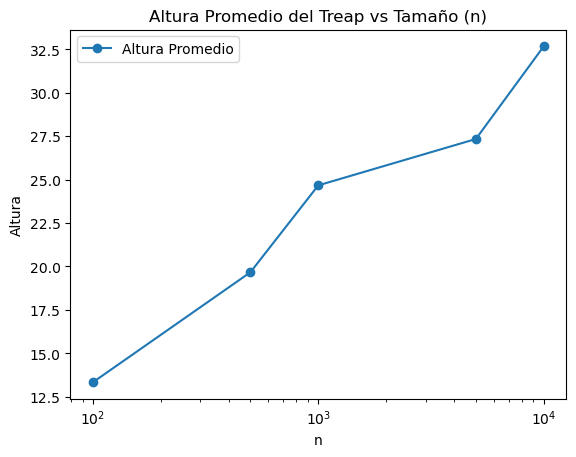

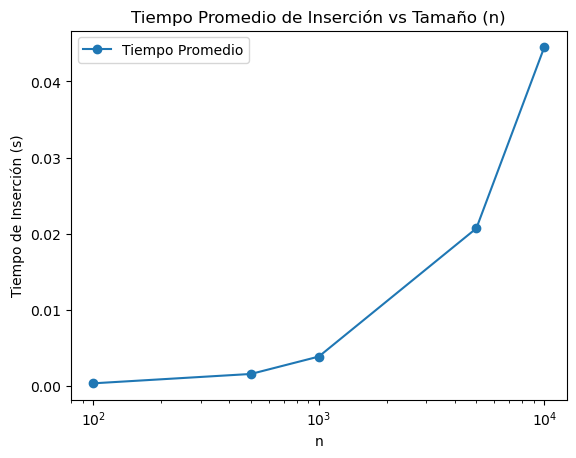

In [5]:
import time
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from typing import List

# Se asume que la implementación de Treap y sus clases internas ya están definidas/importadas.
# Ejemplo: from treap import Treap

def profile_treap_insertion(sizes: List[int], num_runs: int = 5) -> pd.DataFrame:
    """
    Ejecuta pruebas de inserción en el Treap para diferentes tamaños, 
    registrando el tiempo total de inserción y la altura final del árbol.

    Args:
        sizes (List[int]): Lista de tamaños n a evaluar.
        num_runs (int): Número de ejecuciones por tamaño.

    Returns:
        pd.DataFrame: Con columnas 'n', 'run', 'time', 'height'
    """
    resultados = []
    for n in sizes:
        for run in range(num_runs):
            treap = Treap()
            inicio = time.perf_counter()  # Alta resolución
            for _ in range(n):
                key = random.randint(0, 1_000_000)
                priority = random.random()
                treap.add(Treap.TreapEntry(key, priority))
            fin = time.perf_counter()
            resultados.append({
                "n": n,
                "run": run,
                "time": fin - inicio,
                "height": treap.height()
            })
    return pd.DataFrame(resultados)

def guardar_csv(df: pd.DataFrame, ruta: str):
    """Guarda el DataFrame en CSV. Se captura excepción si ocurre algún error."""
    try:
        df.to_csv(ruta, index=False)
        print(f"CSV guardado en: {ruta}")
    except Exception as e:
        print(f"Error al guardar CSV: {e}")

def plot_test_case_means(df: pd.DataFrame, groupby_field: str, value_fields: List[str]):
    fig, ax = plt.subplots()
    ax.set_xlabel(groupby_field)
    ax.set_ylabel("Valor")
    ax.set_yscale("log", base=10)
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_yticks([1, 2, 5, 10, 20, 50, 100, 500, 1000])
    for field in value_fields:
        data = df.groupby(groupby_field).mean().reset_index()
        ax.plot(data[groupby_field], data[field], marker='o', label=field)
    ax.legend()
    plt.title("Medias de las estadísticas")
    plt.show()

def plot_individual_graphs(df: pd.DataFrame):
    fig1, ax1 = plt.subplots()
    ax1.set_xlabel("n")
    ax1.set_ylabel("Altura")
    ax1.set_title("Altura Promedio del Treap vs Tamaño (n)")
    ax1.plot(df["n"], df["height"], marker='o', label="Altura Promedio")
    ax1.set_xscale("log")
    ax1.legend()
    plt.show()

    fig2, ax2 = plt.subplots()
    ax2.set_xlabel("n")
    ax2.set_ylabel("Tiempo de Inserción (s)")
    ax2.set_title("Tiempo Promedio de Inserción vs Tamaño (n)")
    ax2.plot(df["n"], df["time"], marker='o', label="Tiempo Promedio")
    ax2.set_xscale("log")
    ax2.legend()
    plt.show()

## Pruebas de codigo
random.seed(42)
sizes = [100, 500, 1000, 5000, 10000]
num_runs = 3
df_profiling = profile_treap_insertion(sizes, num_runs)
print("Datos de profiling:")
print(df_profiling.head())
ruta_csv = "treap_profiling_results.csv"
guardar_csv(df_profiling, ruta_csv)
df_profiling["log_n"] = df_profiling["n"].apply(lambda x: math.log(x, 2))
plot_test_case_means(df_profiling, "n", ["height", "time", "log_n"])
df_grouped = df_profiling.groupby("n").mean().reset_index()
plot_individual_graphs(df_grouped)


#### Ejercicios

##### **1: Modularización y refactorización de la implementación del Treap**

Divide el código en módulos separados para mejorar la mantenibilidad y legibilidad. Por ejemplo, separar la clase para el nodo del árbol (Node) de la implementación principal del Treap.

**Pasos sugeridos:**  
1. Crea un archivo `node.py` que contenga la definición de la clase `Node` (o `_TreapNode` en tu implementación actual).  
2. Crea otro archivo `treap.py` con la clase `Treap` y usa `from node import Node` para incorporarla.  
3. En el archivo `node.py`, documenta claramente cada método y define los "setters" para los hijos. Usa el siguiente pseudocódigo como guía:

   ```
   class Node:
       key             # tipo: double (o el tipo adecuado)
       priority        # tipo: double o similar
       left            # tipo: Node
       right           # tipo: Node
       parent          # tipo: Node

       function Node(key, priority)
           (this.key, this.priority) ← (key, priority)
           this.left ← null
           this.right ← null
           this.parent ← null

       function setLeft(node)
           this.left ← node
           if node != null then
               node.parent ← this

       function setRight(node)
           this.right ← node
           if node != null then
               node.parent ← this
   ```

2.  Refactoriza la parte de rotaciones usando funciones separadas (por ejemplo, `rightRotate(treap, x)` y `leftRotate(treap, x)`) siguiendo de cerca el pseudocódigo.


##### **Ejercicio2: Mejora de la seguridad en hilos (Thread-Safety) y pruebas concurrentes**

Fortalece la compatibilidad con ejecución concurrente y validar con tests que operaciones simultáneas en el Treap (inserción, eliminación y actualización) se comporten correctamente.

**Pasos sugeridos:**  
1. Añade pruebas unitarias específicas para concurrencia. Por ejemplo, crea varios hilos que inserten y eliminen nodos al mismo tiempo.  
2. Verifica que las invariantes (por ejemplo, la propiedad de heap y BST) se mantengan al final de todas las operaciones concurrentes.  
3. Agrega "locking" en las operaciones críticas si fuera necesario (en tu implementación ya usas `RLock`, pero investiga si se pueden optimizar bloqueos en operaciones de solo lectura).  
4. Genera un pseudocódigo de un test concurrente:

   ```
   function test_concurrent_insert_remove():
       crear treap
       definir función insertor():
           repetir N veces:
               insertar nodo aleatorio en treap

       definir función removedor():
           repetir M veces:
               eliminar nodo aleatorio en treap

       lanzar hilos para insertor y removedor en paralelo
       esperar a que terminen todos los hilos
       verificar invariantes del treap
   ```


##### **Ejercicio 3: Optimización y comparación iterativa vs. recursiva en operaciones**

Investiga posibles mejoras en la eficiencia del Treap comparando implementaciones recursivas e iterativas, por ejemplo, en la función de inserción y actualización de prioridad.

**Pasos sugeridos:**  
1. Implementa una versión iterativa para la función de inserción (y/o eliminación) utilizando ciclos `while` en lugar de recursión.  
2. Mide el rendimiento usando el código de profiling actual; registra el tiempo de inserción en ambos casos.  
3. Realiza una gráfica comparativa de las diferencias de tiempo.  
4. Pseudocódigo para una inserción iterativa:

   ```
   function insert_iterative(treap, key, priority):
       newNode ← new Node(key, priority)
       current ← treap.root
       parent ← null
       while current != null do:
           parent ← current
           if key < current.key then:
               current ← current.left
           else:
               current ← current.right
       if parent == null then:
           treap.root ← newNode
       else if key < parent.key:
           parent.setLeft(newNode)
       else:
           parent.setRight(newNode)
       while newNode.parent != null and newNode.priority < newNode.parent.priority do:
           if newNode is parent's left child then:
               rightRotate(treap, newNode)
           else:
               leftRotate(treap, newNode)
   ```

2. Modifica la función `profile_treap_insertion` para parametrizar qué versión usar e incorpora una columna adicional en el DataFrame para comparar tiempos.

##### **Ejercicio 4: Extender la funcionalidad del Treap (Iteradores e in-order Traversal)**

Añade la capacidad de iterar sobre el Treap en orden (in-order traversal) para facilitar, por ejemplo, la extracción ordenada de elementos o su verificación.

**Pasos sugeridos:**  
1. Añade un método `in_order_traversal()` en la clase Treap que retorne una lista de nodos o claves en orden.  
2. Implementa el método `__iter__` en la clase Treap para poder iterar directamente sobre sus elementos.  
3. Pseudocódigo para el recorrido in-order:

   ```
   function in_order_traversal(node):
       if node == null then:
           return empty_list
       return in_order_traversal(node.left) + [node.key] + in_order_traversal(node.right)
   ```

2. Agrega pruebas unitarias que verifiquen que la lista retornada es efectivamente la secuencia de claves ordenadas.


##### **Ejercicio 5: Mejorar y ampliar las pruebas unitarias y de profiling**

Revisa las pruebas actuales y añadir casos de borde y escenarios extendidos, además de mejorar los gráficos y el guardado de resultados.

**Pasos sugeridos para pruebas unitarias:**  
1. Escribe pruebas adicionales que verifiquen el comportamiento ante la inserción de claves duplicadas y la eliminación parcial de duplicados (si es que el Treap permite duplicados).  
2. Verifica que la función `update_priority` no solo actualiza la prioridad, sino que mantiene las invariantes del Treap.  
3. Añade casos en los que se realicen múltiples llamadas consecutivas a `clear()` y se verifique que el árbol se reinicia correctamente.

**Pasos sugeridos para el profiling:**  
1. En el código de profiling, crea funciones para generar gráficos separados que comparen (por ejemplo, altura versus tamaño y tiempo versus tamaño) usando escalas logarítmicas donde proceda.  
2. Añade un guardado de gráficos (por ejemplo, en formato `png`) para incorporar a reportes automáticos.  
3. Parametriza el número de repeticiones y tamaños a testear, permitiendo probar con tamaños mucho mayores de forma opcional.

**Pseudocódigo para extender el profiling:**

```
function profile_treap_insertion(sizes, num_runs):
    for each n in sizes do:
       for run from 1 to num_runs do:
          inicializar treap
          tiempo_inicio ← current_time
          for i = 1 to n do:
              treap.insert(random_key, random_priority)
          tiempo_fin ← current_time
          registrar n, run, (tiempo_fin - tiempo_inicio), treap.height()
    retornar DataFrame con resultados
```

##### **Ejercicio 6: Implementar operaciones de fusión (merge) entre dos Treaps**

Extendiende la funcionalidad implementando una función que permita unir (merge) dos Treaps en uno solo, manteniendo las propiedades de BST y heap.

**Pasos sugeridos:**  
1. Investiga el algoritmo de merge para Treaps (normalmente se usa una fusión basada en prioridades).  
2. Implementa la función `merge(treap1, treap2)` que retorne un nuevo Treap que contenga todos los elementos de ambos, sin perder la invariante.  
3. Escribe pruebas unitarias que verifiquen que la fusión se realiza correctamente (por ejemplo, que la secuencia in-order sea la unión ordenada de ambas secuencias).

**Pseudocódigo sugerido:**

```
function merge(treap1, treap2):
    if treap1.root == null then:
        return treap2
    if treap2.root == null then:
        return treap1
    if treap1.root.priority < treap2.root.priority then:
        treap1.root.right ← merge(treap1.root.right, treap2)
        return treap1
    else:
        treap2.root.left ← merge(treap1, treap2.root.left)
        return treap2
```

##### **Ejercicio 7: Ampliar las operaciones de búsqueda y recorridos** 
 
Extiende la funcionalidad del Treap para incluir más métodos de búsqueda (por ejemplo, búsqueda por rango) y diferentes recorridos (pre-order, post-order, level-order).

**Pasos sugeridos:**  
1. **Búsqueda por rango:**  
   - Implementa un método `search_range(inicio, fin)` que retorne todos los nodos cuyas claves se encuentren entre `inicio` y `fin` (inclusivo o exclusivo, según la necesidad).  
   - **Pseudocódigo ejemplo:**
     ```
     function search_range(node, inicio, fin):
         if node == null then
             return empty_list
         result ← empty_list
         if node.key > inicio then
             result ← result + search_range(node.left, inicio, fin)
         if inicio <= node.key and node.key <= fin then
             result.append(node.key)
         if node.key < fin then
             result ← result + search_range(node.right, inicio, fin)
         return result
     ```
2. **Recorrido level-order (por niveles):**  
   - Crea un método `level_order_traversal()` que use una cola para recorrer el árbol de manera iterativa y devolver la lista de claves por nivel.  
   - Este método es útil para visualizar la distribución y la estructura del árbol.

3. **Pruebas unitarias:**  
   - Agrega tests que verifiquen la corrección de estos recorridos y la búsqueda por rango, asegurando que la secuencia de los elementos sea la esperada.

##### **Ejercicio 8: Integración de logging para trazabilidad y debugging**

Incorpora capacidades de logging en las operaciones críticas del Treap para facilitar la depuración en tiempo de ejecución, especialmente en escenarios concurrentes o cuando se realizan transformaciones complejas (rotaciones, actualización de prioridades, etc.).

**Pasos sugeridos:**  
1. Añade un módulo de logging (por ejemplo, usando el módulo `logging` de Python) configurado para captar y registrar mensajes con distintos niveles (DEBUG, INFO, WARNING, ERROR).  
2. Inserta logs en métodos claves como:  
   - Inserción de un nodo.  
   - Rotaciones (izquierda y derecha).  
   - Actualización de prioridad.  
   - Eliminación de nodos.  
3. **Pseudocódigo ejemplo:**
   ```
   function insert(treap, key, priority):
       log.info("Insertando nodo con clave: " + key + " y prioridad: " + priority)
       ... (algoritmo de inserción) ...
       if se realiza una rotación then:
           log.debug("Rotación realizada en nodo con clave: " + key)
       log.info("Inserción completada")
   ```
4. Asegura de que los logs sean opcionales o configurables para no impactar el rendimiento en producción.


##### **Ejercicio 9: Validación de estructuras y verificación de invarianzas**  

Desarrolla métodos que verifiquen la consistencia interna del árbol más allá de las invarianzas de Treap (por ejemplo, consistencia de apuntadores a padres, estructura del árbol completo y balance esperado).

**Pasos sugeridos:**  
1. Crea un método `validate_structure()` que recorra el árbol y verifique que:  
   - Todos los nodos tengan sus punteros `parent` correctamente asignados.  
   - La propiedad de BST se cumpla en cada nodo, y que no existan bucles o referencias cíclicas.  
2. Amplia el método de validación de invarianzas para que detecte posibles inconsistencias introducidas por errores en la actualización de prioridades o en eliminaciones.  
3. **Pseudocódigo ejemplo:**
   ```
   function validate_structure(node):
       if node == null then
           return true
       if node.left != null:
           if node.left.parent != node or node.left.key > node.key then
               return false
           if not validate_structure(node.left):
               return false
       if node.right != null:
           if node.right.parent != node or node.right.key <= node.key then
               return false
           if not validate_structure(node.right):
               return false
       return true
   ```
4. Incluye pruebas unitarias que inserten y eliminen nodos de manera aleatoria y, al final, invoquen este método para asegurar la integridad del árbol.


##### **Ejercicio 10: Creación de interfaces interactivas y visualización dinámica**  

Facilita la comprensión y análisis visual de la estructura del Treap mediante la integración de herramientas interactivas (por ejemplo, en Jupyter Notebook) que permitan ver el árbol en tiempo real.

**Pasos sugeridos:**  
1. Utiliza bibliotecas como `matplotlib` o `graphviz` para crear funciones que representen visualmente el Treap.  
   - Por ejemplo, un método `plot_tree()` que genere un gráfico con nodos y enlaces que representen la jerarquía.  
2. Implementa funciones interactivas (posiblemente usando `ipywidgets` en notebooks) que permitan:  
   - Insertar/eliminar nodos manualmente y actualizar la visualización.  
   - Resaltar las rotaciones durante la actualización de prioridades o inserciones.
3. **Pseudocódigo para una función de visualización:**
   ```
   function plot_tree(node, ax, x, y, dx):
       if node == null then
           return
       plot nodo en (x, y) con etiqueta node.key
       if node.left != null then:
           dibujar línea desde (x, y) hasta (x - dx, y - level_gap)
           plot_tree(node.left, ax, x - dx, y - level_gap, dx/2)
       if node.right != null then:
           dibujar línea desde (x, y) hasta (x + dx, y - level_gap)
           plot_tree(node.right, ax, x + dx, y - level_gap, dx/2)
   ```
4. Crea un notebook de ejemplo donde se puedan probar estas funciones y ver el efecto de las operaciones en el Treap de forma interactiva.


##### **Ejercicio 11: Generación y ejecución automatizada de benchmarks con diferentes configuraciones** 

Amplia el framework de profiling para probar no solo la inserción, sino también la búsqueda, eliminación y actualización de prioridades en diferentes configuraciones, y automatizar la ejecución de benchmarks con reportes.

**Pasos sugeridos:**  
1. Extiende el script de profiling para medir el rendimiento de:  
   - Búsqueda de nodos en el Treap.  
   - Eliminación de nodos.  
   - Actualización de prioridades.  
2. Crea funciones de benchmarking separadas para cada operación, registrando:  
   - Tiempo de ejecución.  
   - Tamaño del árbol final.  
   - Altura del árbol después de cada operación.
3. Usa un framework de benchmarks como `timeit` o incluso `perfplot` para visualizar cómo varía el rendimiento con el tamaño del árbol.  
4. **Pseudocódigo para benchmarking:**
   ```
   function benchmark_operation(operation, sizes, num_runs):
       for each n in sizes do:
           for run in 1 to num_runs:
               inicializar treap con n elementos
               tiempo_inicio ← current_time
               ejecutar operación (búsqueda/eliminación/actualización)
               tiempo_fin ← current_time
               registrar n, run, (tiempo_fin - tiempo_inicio), treap.height()
       return DataFrame con resultados
   ```
5. Compara los resultados obtenidos con los teóricos (por ejemplo, se espera una complejidad logarítmica en promedio) y documentar las observaciones.


##### **Ejercicio 12: Implementación de persistencia y serialización**

Añade funcionalidades para guardar el estado completo del Treap en disco (por ejemplo, en formato JSON o binario) y permitir su posterior reconstrucción. Esto es útil para aplicaciones donde se requiera persistencia de datos.

**Pasos sugeridos:**  
1. Desarrolla métodos `serialize()` y `deserialize(data)` en la clase Treap o en un módulo auxiliar.  
   - `serialize()` debe recorrer el árbol y generar una representación estructurada (por ejemplo, un diccionario anidado) que incluya claves, prioridades y relaciones de parentesco.  
   - `deserialize(data)` reconstruirá el árbol a partir del diccionario, reestableciendo todas las relaciones.
2. **Pseudocódigo para serialización:**
   ```
   function serialize(node):
       if node == null then:
           return null
       return {
           "key": node.key,
           "priority": node.priority,
           "left": serialize(node.left),
           "right": serialize(node.right)
       }
   ```
3. Prueba la persistencia realizando la serialización, guardando el resultado en un archivo (por ejemplo, usando `json.dump`), y luego reconstruyendo el Treap desde el archivo.  
4. Agrega pruebas unitarias para validar que, tras la deserialización, el árbol mantiene sus propiedades y la misma secuencia de claves en el recorrido in-order.

In [ ]:
## Tus respuestas